**Projeto Análise de Dados**


*Este bloco de notas contém todo o código usado para processamento e análise exploratória dos dados relevantes e formatados para aplicação das técnicas de análise de dados e consequente criação de um modelo de classificação*

Este bloco de notas recebe como entrada o arquivo construído e fornecido pelo bloco de notas usado para seleção, limpeza e transformação (extração, transformação, carregamento ou ETL, do inglês Extract Transform Load).
O arquivo de entrada contém uma tabela cujas linhas contêm os bairros presentes no arquivo ATIVECO_ES (mapeadas para os códigos de bairros do IBGE) e cujas colunas contêm as atividades presentes no arquivo ATIVECO_ES (mapeadas para os códigos de atividades do CNAE agrupados por DIVISÃO). O conteúdo de cada célula da tabela contém a quantidade daquela atividade (coluna) naquele bairro (linha). O arquivo de saida servirá de entrada para o próximo módulo (bloco de notas) de Exploração dos Dados.


Após a análise exploratório definiu-se como saida do processamento desse bloco de notas uma separação em grupos (ou *clusters*) de bairros atravês da aplicação da técnica de aprendizado não Supervisionado (os dados de treinamento não são rotulados, ou seja, sistema tenta aprender sem um professor) denominada *k-Means*.

Para a análise exploratória são utilizadas técnicas de visualização e redução da dimensionalidade denominada Análise de Componentes Principais (PCA, do inglês *Principal Component Analysis*) e variância explicada (*explained variance*), técnicas estatísticas para escalar os valores-alvo da base denomiandas (escala min-max e padronização) e técnicas estatísticas e matemáticas para encontrar o número ideal de clusters denominadas Método Cotovelo (do inglês *Elbow Method*), distância ponto a reta e coeficiente de Silhouette (*silhouette score*).



# Setup

Primeiro, vamos importar alguns módulos comuns, garantir que o MatplotLib plote figuras em linha e preparar uma função para salvar as figuras. Também verificamos se o Python 3.5 ou posterior está instalado (embora o Python 2.x possa funcionar, ele está obsoleto, por isso recomendamos fortemente que seja usado o Python 3), bem como o Scikit-Learn ≥0.20.

In [1]:
# Python ≥3.5
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


DATA_PATH_INPUT= os.path.join(".", "INPUT")
DATA_PATH_OUTPUT = os.path.join(".","OUTPUT")

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    DATA_PATH_OUTPUT_IMAGE = os.path.join("OUTPUT", "Imagens")
    if not os.path.isdir(DATA_PATH_OUTPUT_IMAGE):
        os.makedirs(DATA_PATH_OUTPUT_IMAGE)
    path = os.path.join(DATA_PATH_OUTPUT_IMAGE, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Carregando os dados do arquivo físico

In [2]:
import pandas as pd

def load_data_pivot(data_path=DATA_PATH_INPUT):
    csv_path = os.path.join(data_path, "600Pivot_Flat.csv")
    return pd.read_csv(csv_path)

In [3]:
### Leitura da base de dados com cada bairro ("Cód.", "Município", "Bairro") nas linhas 
### Cada atividade nas colunas
Cluster_Flat = load_data_pivot()

# Adequação dos dados para uma mesma escala

A tabela carregada do arquivo contém dados absolutos, ou seja, a quantidade de atividades por bairro.  Com poucas exceções, os algoritmos de Aprendizado de Máquina não funcionam bem quando atributos numéricos de entrada têm escalas muito diferentes. O escalonamento das características possibilita comparações relativas que, por sua vez, permitem melhor funcionamento dos algoritmos

Há duas maneiras comuns de fazer com que todos os atributos tenham a mesma escala: escalonamento mínimo-máximo (*min-max scaling*) e padronização (*standardization*).


O escalonamento min-max (muitas pessoas chamam de normalização) é bastante simples: os valores são deslocados e redimensionados para que acabem variando de 0 a 1. Fazemos isso subtraindo o valor mínimo e dividindo pelo máximo menos o mínimo.

A padronização é bem diferente: em primeiro lugar ela subtrai o valor médio (assim os valores padronizados sempre têm média zero) e, em seguida, divide pela variância, de modo que a distribuição resultante tenha variância unitária. 

Abaixo, aplicamos a padronização.



In [4]:
### Padronizar a base para que cada linha tenha média zero e variância unitária
## Copia base original
Cluster_StandardScaler = Cluster_Flat.copy()


## Computes the mean of the entire numeric dataframe
mean = Cluster_StandardScaler[Cluster_StandardScaler.columns[3:]].mean().mean()
print(mean)

## Computes the standart deviation of the entire numeric dataframe
## pandas
sd01 = Cluster_StandardScaler[Cluster_StandardScaler.columns[3:]].stack().std()
print(sd01)
## numpy
#sd02 = Cluster_StandardScaler[Cluster_StandardScaler.columns[3:]].values.std(ddof=1)
#print(sd02)

## Computes the variance of the entire numeric dataframe
## pandas
var01 = Cluster_StandardScaler[Cluster_StandardScaler.columns[3:]].stack().var()
print(var01)
## numpy
#var02 = Cluster_StandardScaler[Cluster_StandardScaler.columns[3:]].values.var(ddof=1)
#print(var02)


## para cada célula x[i,j] do dataframe, calcula (x(i,j)-mean)/(sd)
#iterate through each row and column of dataframe. Each column sum = 1.0
for index, row in Cluster_StandardScaler.iterrows():
    for col in Cluster_StandardScaler.columns[3:]:
        #print(Cluster_StandardScaler.at[index,col]/Cluster_StandardScaler.at[index,'sum'])
        Cluster_StandardScaler.at[index,col] = (Cluster_StandardScaler.at[index,col]-mean)/(sd01)

csv_path = os.path.join(DATA_PATH_OUTPUT, "400Cluster_StandardScaler.csv")
Cluster_StandardScaler.to_csv(csv_path, index=True, header=True)
print("400", Cluster_StandardScaler.shape)

7.410369013016555
36.67774934890957
1345.2572973014364
400 (386, 85)


In [5]:
### Conferindo a média zero
mean = Cluster_StandardScaler[Cluster_StandardScaler.columns[3:]].mean().mean()
print(mean)

8.800548365931119e-18


In [6]:
### Conferindo variância unitária
var01 = Cluster_StandardScaler[Cluster_StandardScaler.columns[3:]].stack().var()
print(var01)
## numpy
#var02 = Cluster_StandardScaler[Cluster_StandardScaler.columns[3:]].values.var(ddof=1)
#print(var02)


#sd01 = Cluster_StandardScaler[Cluster_StandardScaler.columns[3:]].stack().std()
#print(sd01)
## numpy
#sd02 = Cluster_StandardScaler[Cluster_StandardScaler.columns[3:]].values.std(ddof=1)
#print(sd02)




0.9999999999998594


#### A próxima célula apresenta o código do escalonamento min-max
Após testes computacionais, o escalonamento min-max mostrou-se menos promissor que a padronização usada nas células acima. Dessa forma ela foi removida do processo de análise exploratória, mas mantida aqui para conhecimneto do código.

In [7]:
### Leitura da base de dados com cada bairro ("Cód.", "Município", "Bairro") nas linhas 
### Cada atividade nas colunas
#Cluster_Flat = load_data_pivot()

### Normaliza a base para que cada linha tenha um somatório de 1.0
## Copia base original
#Cluster_Normalized = Cluster_Flat.copy()
## Gera coluna com o somatório absoluto de cada linha
#Cluster_Normalized['sum'] = Cluster_Normalized[Cluster_Normalized.columns[3:]].sum(axis=1)

### Divide cada célula de uma linha pelo somatório daquela linha       
##iterate through each row and column of dataframe normalizing. Each column sum = 1.0
#for index, row in Cluster_Normalized.iterrows():
#    for col in Cluster_Normalized.columns[3:]:
#        #print(Cluster_Normalized.at[index,col]/Cluster_Normalized.at[index,'sum'])
#        Cluster_Normalized.at[index,col] = Cluster_Normalized.at[index,col]/Cluster_Normalized.at[index,'sum']

## Remove coluna com o somatório de cada linha (= 1.0, depois da normalização)
#Cluster_Normalized = Cluster_Normalized.drop('sum', axis='columns')        

#csv_path = os.path.join(DATA_PATH_OUTPUT, "300Cluster_Normalized.csv")
#Cluster_Normalized.to_csv(csv_path, index=True, header=True)
#print("300", Cluster_Normalized.shape)

## Gera uma linha com o total de cada coluna
## A coluna com maior total, será a atividade com maior representatividade relativa
#Cluster_Normalized.loc["Total"] = Cluster_Normalized[Cluster_Normalized.columns[3:]].sum()

#Cluster_Normalized.loc["Count"] = (Cluster_Normalized[Cluster_Normalized.columns[3:]] > 0).sum()

### Ordena as colunas pela representatividade relativa
## as colunas iniciais possuem as atividades mais representativas
## sort Dataframe columns based on "Total" row
#Cluster_Normalized = Cluster_Normalized.sort_values(by = ['Total'], axis = 1, ascending = False)

#csv_path = os.path.join(DATA_PATH_OUTPUT, "301Cluster_Normalized_Order_Total.csv")
#Cluster_Normalized.to_csv(csv_path, index=True, header=True)
#print("301", Cluster_Normalized.shape)

## Remove linha com o total de cada coluna
#Cluster_Normalized = Cluster_Normalized.drop(['Total'])

## Reorganiza a ordem das colunas para que as tres primeiras colunas contenham as informações de bairros
## ("Cód.", "Município", "Bairro")
# Changing the order of DataFrame columns
#cols = Cluster_Normalized.columns.tolist()
#print(cols)
#cols = cols[-3:] + cols[:-3]
#print(cols)
#Cluster_Normalized = Cluster_Normalized[cols]

#csv_path = os.path.join(DATA_PATH_OUTPUT, "302Cluster_Normalized_Sorted.csv")
#Cluster_Normalized.to_csv(csv_path, index=True, header=True)
#print("302", Cluster_Normalized.shape)

# Redução de dimensionalidade

A Análise dos Componentes Principais (PCA, do inglês *Principal Component Analysis*) é o algoritmo de redução de dimensionalidade mais popular. Primeiro, ele identifica o hiperplano que se encontra mais próximo dos dados e, então, projeta os dados sobre ele.

Em vez de escolher arbitrariamente o número de dimensões a serem reduzidas, é preferível escolher o número de dimensões que adicionam uma porção suficientemente grande de variância (por exemplo, 95%). A menos que o objetivo seja reduzir a dimensionalidade para a visualização de dados — nesse caso, reduzir a dimensionalidade para 2 ou 3.

A **taxa de variância explicada** indica a proporção da variância do conjunto de dados que se encontra ao longo do eixo de cada componente principal.

Abaixo uma função que plota a variação explicada como uma função do número de dimensões.
A função também plota a redução de dimensionalidade para a visualização de dados com dimensão = 2.

In [8]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter



# df = dataframe
# col = numeric columns to be used 
# plot X_Axis, Y_Axis and saves as fig_name
def PCA_Plot(df,col,fig_name):

    
    ## Dimensões do conjunto de dados para taxa de variância explicada em 95%.    
    pca = PCA()
    pca.fit(df[df.columns[col:]])
 
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    #print(cumsum)
    d = np.argmax(cumsum >= 0.95) + 1
    e = np.argmax(cumsum >= 0.85) + 1
    
    plt.figure(figsize=(6,4))
    #plt.plot(cumsum, linewidth=3)
    plt.plot(range(1, len(cumsum)+1), cumsum, "bo-")
    plt.axis([0, 70, 0, 1])
    plt.xlabel("Dimensions")
    plt.ylabel("Explained Variance")
    plt.plot([d, d], [0, 0.95], "k:")
    plt.plot([0, d], [0.95, 0.95], "k:")
    plt.plot(d, 0.95, "ko")
    plt.annotate("95% = "+ str(d), xy=(d, 0.95), xytext=(40, 0.7), arrowprops=dict(arrowstyle="->"), fontsize=16)
    #plt.annotate("85% = "+ str(e), xy=(e, 0.85), xytext=(30, 0.5), arrowprops=dict(arrowstyle="->"), fontsize=16)
    #plt.annotate('{:.0f}%'.format(cumsum[1]*100) + " = 2", xy=(2, cumsum[1]), xytext=(20, 0.3), arrowprops=dict(arrowstyle="->"), fontsize=16)
    plt.grid(True)
    save_fig(fig_name)
    plt.show()
    
    
    ## Dimensionality Reduction using Scikit-Learn
    # Two dimensions using only the numeric columns
    pca = PCA(n_components=2)
    R2D = pca.fit_transform(df[df.columns[col:]])
    
    ## Acrescenta as dimensões reduzidas na base original como as últimas duas colunas
    df_2D = df.copy()
    df_2D["X2D"] = R2D[:,0]
    df_2D["Y2D"] = R2D[:,1]
    X_Axis = -2
    Y_Axis = -1
    
    ## Imprime gráfico com as dimensões reduzidas
    plt.plot(df_2D[df_2D.columns[X_Axis]],
         df_2D[df_2D.columns[Y_Axis]],
         "yo", label="vizualização PCA")
    plt.xlabel(df_2D.columns[X_Axis], fontsize=14)
    plt.ylabel(df_2D.columns[Y_Axis], fontsize=14)
    plt.legend(loc="best", fontsize=12)
    save_fig(fig_name + '_DR')
    plt.show()
   
    return df_2D 

Saving figure 01PCA


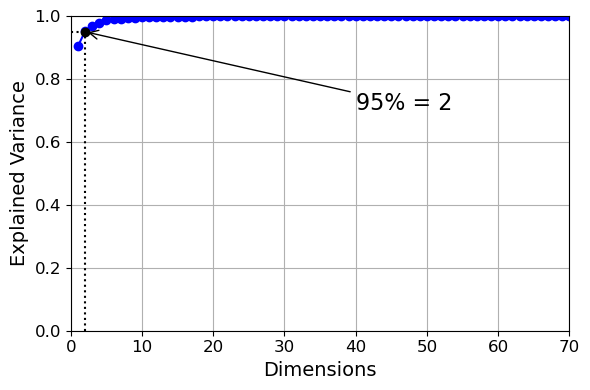

Saving figure 01PCA_DR


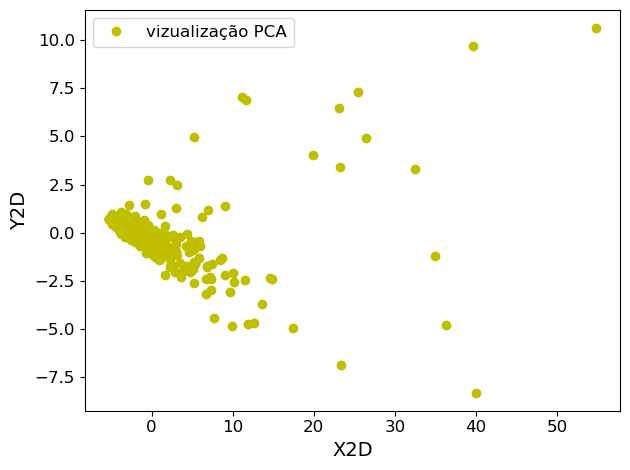

403 (386, 87)


In [9]:
Cluster_StandardScaler_DR = PCA_Plot(Cluster_StandardScaler, 3, "01PCA")

csv_path = os.path.join(DATA_PATH_OUTPUT, "403Cluster_StandardScaler_DR.csv")
Cluster_StandardScaler_DR.to_csv(csv_path, index=True, header=True)
print("403", Cluster_StandardScaler_DR.shape)

É possível verificar no gráfico acima (01PCA.png) que com apenas duas dimensões tem-se uma variância explicada de 95%, podendo assim ser escolhida como o número de dimensões suficientemente representativo.

O segundo gráfico (01PCA_DR.png) mostra a distribuição dos bairros pelas duas dimensões PCA. Abaixo analisamos os pontos extremos.

### Vizualizando os extremos para intuição

Podemos verificar que os pontos extremos representam bairros intuitivamente semelhantes. Com concentração de comércio e auto-suficientes.

In [10]:
print(Cluster_StandardScaler_DR.loc[Cluster_StandardScaler_DR["Y2D"] > 5.0, ["Município","Bairro"]])

      Município           Bairro
276  VILA VELHA   PRAIA DA COSTA
315     VITÓRIA           CENTRO
325     VITÓRIA   ENSEADA DO SUÁ
343     VITÓRIA   JARDIM CAMBURÍ
344     VITÓRIA  JARDIM DA PENHA
370     VITÓRIA      SANTA LÚCIA


In [11]:
print(Cluster_StandardScaler_DR.loc[Cluster_StandardScaler_DR["Y2D"] < -4.0, ["Município","Bairro"]])

      Município                Bairro
11    CARIACICA          CAMPO GRANDE
127       SERRA              FEU ROSA
131       SERRA       JARDIM CARAPINA
152       SERRA        NOVO HORIZONTE
195       SERRA  VILA NOVA DE COLARES
207       VIANA   MARCILIO DE NORONHA
223  VILA VELHA            BARRAMARES
241  VILA VELHA                GLÓRIA


# Clustering (agrupamento)

Se não é possível definir os grupos a partir da base de dados, utiliza-se um algoritmo de clustering (aprendizado não supervisionado) para segmentar seus objetos de estudo (bairros) em grupos de  bairros semelhantes.

A função abaixo recebe uma base de dados e o número de clusters e associa cada bairro a um cluster diferente.
A função retorna a mesma base de dados com uma coluna a mais denominada "pred" com a identificação (número inteiro) do cluster ao qual aquela linha (bairro) foi atribuída.
A função imprime uma figura com os bairros agrupados em diferentes cores.

In [12]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter



# k = number of clusters
# df = dataframe
# [first,end] range of numeric columns to be clustered
# plot X_Axis, Y_Axis and saves as fig_name
def Kmeans_Plot(k,df,first,end, X_Axis,Y_Axis,fig_name):
    #https://matplotlib.org/3.5.3/api/_as_gen/matplotlib.pyplot.plot.html#matplotlib.pyplot.plot
    #MarkerAbbreviations = ('.',',','o','v','^','<', '>','1','2','3','4','8','s','p','P','*','h','H','+','x','X','D','|','_')
    CollorAbbreviations = ('y','b','g','r','c','m','k','y','b','g','r','c','m','k','y','b','g','r','c','m','k')
    MarkerAbbreviations = ('o','s','^','<', '>','1','2','3','4','8','p','P','*','h','H','+','x','X','D','|','_','v')

    
    ## Cria k clusters    
    kmeans = KMeans(n_clusters=k,n_init=10,random_state=42)
    #labels = kmeans.fit_predict(df[[df.columns[X_Axis],df.columns[Y_Axis]]])
    labels = kmeans.fit_predict(df[df.columns[first:end]])
    
    ## Acrescenta os clusters como a última coluna
    df_Pred = df.copy()
    df_Pred["pred"]=labels
    X_Axis = X_Axis-1
    Y_Axis = Y_Axis-1    

    ## Imprime gráfico com as dimensões reduzidas e os clusters
    for i in range(0,k):
        plt.plot(
            df_Pred[df_Pred["pred"]==i][df_Pred.columns[X_Axis]],
            df_Pred[df_Pred["pred"]==i][df_Pred.columns[Y_Axis]],
            CollorAbbreviations[i]+MarkerAbbreviations[i], label="Cluster "+str(i))
    plt.xlabel(df_Pred.columns[X_Axis], fontsize=14)
    plt.ylabel(df_Pred.columns[Y_Axis], fontsize=14)
    plt.legend(loc="best", fontsize=12)
    save_fig(fig_name + '_Cluster_KM_' + str(k))
    plt.show()
    
    ## retorna a base original com as informações de dimensões reduzidas e clusters
    return df_Pred
    
  

# Análise exploratória usando a base de dados original

## Divisão em dois grupos (k = 2)

Saving figure 02_StandardScaler_ORI_Cluster_KM_2


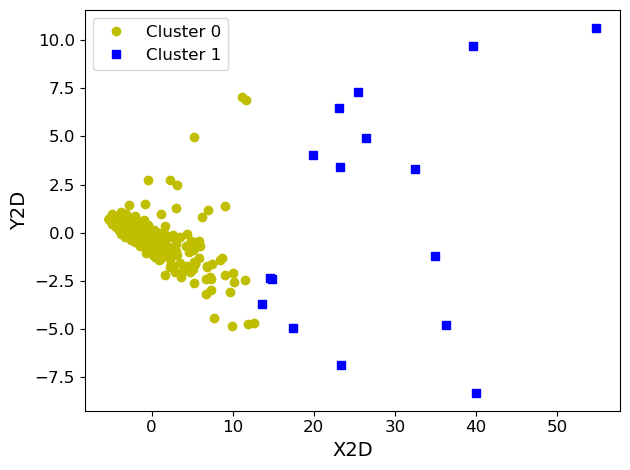

404 (386, 88)


In [13]:
Cluster_StandardScaler_DR_Cluster = Kmeans_Plot(2,Cluster_StandardScaler_DR, 3, -3, -2, -1, "02_StandardScaler_ORI")

    
csv_path = os.path.join(DATA_PATH_OUTPUT, "404Cluster_StandardScaler_DR_Cluster2.csv")
Cluster_StandardScaler_DR_Cluster.to_csv(csv_path, index=True, header=True)
print("404", Cluster_StandardScaler_DR_Cluster.shape)

## Divisão em três grupos (k = 3)

Saving figure 03_StandardScaler_ORI_Cluster_KM_3


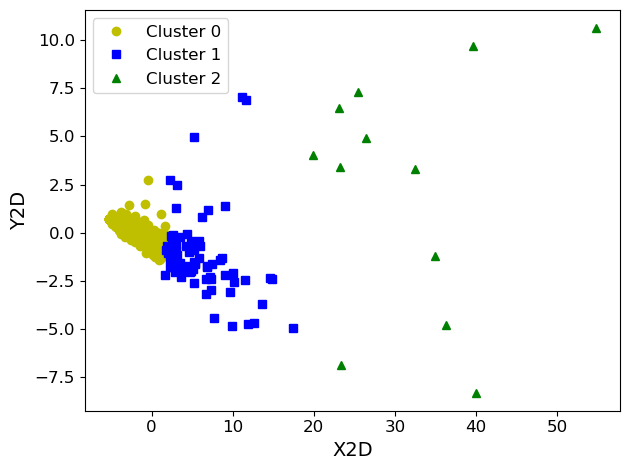

404 (386, 88)


In [14]:
Cluster_StandardScaler_DR_Cluster = Kmeans_Plot(3,Cluster_StandardScaler_DR, 3, -3, -2, -1, "03_StandardScaler_ORI")

    
csv_path = os.path.join(DATA_PATH_OUTPUT, "404Cluster_StandardScaler_DR_Cluster3.csv")
Cluster_StandardScaler_DR_Cluster.to_csv(csv_path, index=True, header=True)
print("404", Cluster_StandardScaler_DR_Cluster.shape)

## Divisão em quatro grupos (k = 4)

Saving figure 04_StandardScaler_ORI_Cluster_KM_4


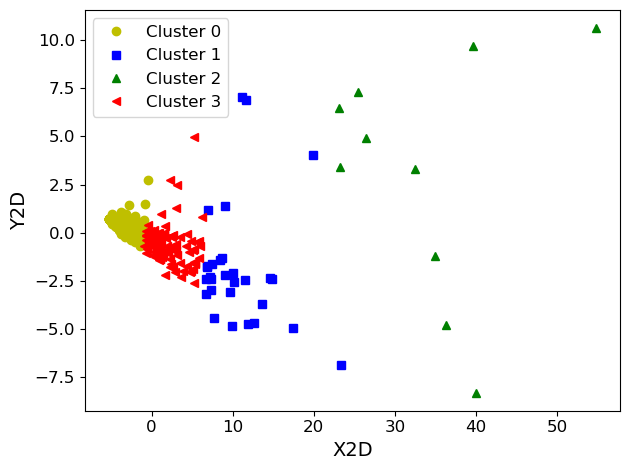

404 (386, 88)


In [15]:
Cluster_StandardScaler_DR_Cluster = Kmeans_Plot(4,Cluster_StandardScaler_DR, 3, -3, -2, -1, "04_StandardScaler_ORI")

    
csv_path = os.path.join(DATA_PATH_OUTPUT, "404Cluster_StandardScaler_DR_Cluster4.csv")
Cluster_StandardScaler_DR_Cluster.to_csv(csv_path, index=True, header=True)
print("404", Cluster_StandardScaler_DR_Cluster.shape)

### Vizualizando os grupos para intuição

In [16]:
print(Cluster_StandardScaler_DR_Cluster.loc[Cluster_StandardScaler_DR_Cluster["pred"] == 2, ["Município","Bairro"]])

      Município                          Bairro
11    CARIACICA                    CAMPO GRANDE
157       SERRA  PARQUE RESIDENCIAL LARANJEIRAS
241  VILA VELHA                          GLÓRIA
250  VILA VELHA                          ITAPUÃ
276  VILA VELHA                  PRAIA DA COSTA
278  VILA VELHA              PRAIA DE ITAPARICA
315     VITÓRIA                          CENTRO
343     VITÓRIA                  JARDIM CAMBURÍ
344     VITÓRIA                 JARDIM DA PENHA
360     VITÓRIA                  PRAIA DO CANTO


In [17]:
print(Cluster_StandardScaler_DR_Cluster.loc[Cluster_StandardScaler_DR_Cluster["pred"] == 1, ["Município","Bairro"]])

      Município                  Bairro
25    CARIACICA                 ITACIBA
29    CARIACICA          JARDIM AMÉRICA
40    CARIACICA      NOVA ROSA DA PENHA
86    CARIACICA           VILA CAPIXABA
98        SERRA               BARCELONA
106       SERRA         CARAPINA GRANDE
127       SERRA                FEU ROSA
131       SERRA         JARDIM CARAPINA
134       SERRA         JARDIM LIMOEIRO
136       SERRA         JARDIM TROPICAL
146       SERRA   MORADA DE LARANJEIRAS
149       SERRA         NOVA CARAPINA I
152       SERRA          NOVO HORIZONTE
174       SERRA        SERRA DOURADA II
195       SERRA    VILA NOVA DE COLARES
207       VIANA     MARCILIO DE NORONHA
219  VILA VELHA                 ARIBIRI
220  VILA VELHA                  ATAÍDE
223  VILA VELHA              BARRAMARES
228  VILA VELHA    CENTRO DE VILA VELHA
233  VILA VELHA              COBILÂNDIA
235  VILA VELHA  COQUEIRAL DE ITAPARICA
238  VILA VELHA   DIVINO ESPÍRITO SANTO
286  VILA VELHA              SANTA INÊS


## Divisão em cinco grupos (k = 5)

Saving figure 05_StandardScaler_ORI_Cluster_KM_5


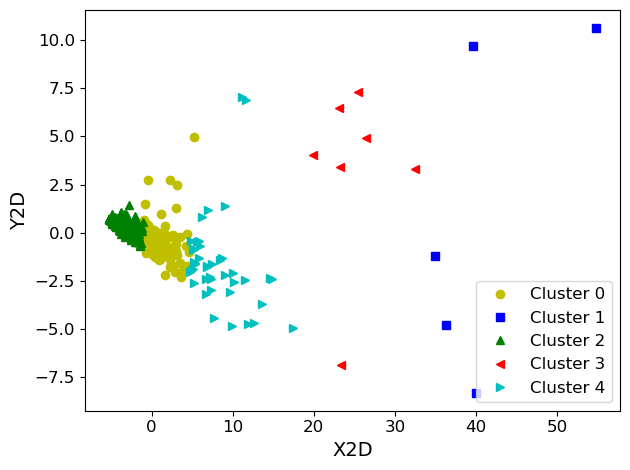

404 (386, 88)


In [18]:
Cluster_StandardScaler_DR_Cluster = Kmeans_Plot(5,Cluster_StandardScaler_DR, 3, -3, -2, -1, "05_StandardScaler_ORI")

    
csv_path = os.path.join(DATA_PATH_OUTPUT, "404Cluster_StandardScaler_DR_Cluster5.csv")
Cluster_StandardScaler_DR_Cluster.to_csv(csv_path, index=True, header=True)
print("404", Cluster_StandardScaler_DR_Cluster.shape)

### Vizualizando os grupos para intuição

In [19]:
print(Cluster_StandardScaler_DR_Cluster.loc[Cluster_StandardScaler_DR_Cluster["pred"] == 1, ["Município","Bairro"]])


print(Cluster_StandardScaler_DR_Cluster.loc[Cluster_StandardScaler_DR_Cluster["pred"] == 3, ["Município","Bairro"]])

print(Cluster_StandardScaler_DR_Cluster.loc[Cluster_StandardScaler_DR_Cluster["pred"] == 4, ["Município","Bairro"]])


      Município                          Bairro
11    CARIACICA                    CAMPO GRANDE
157       SERRA  PARQUE RESIDENCIAL LARANJEIRAS
241  VILA VELHA                          GLÓRIA
276  VILA VELHA                  PRAIA DA COSTA
343     VITÓRIA                  JARDIM CAMBURÍ
      Município                Bairro
127       SERRA              FEU ROSA
228  VILA VELHA  CENTRO DE VILA VELHA
250  VILA VELHA                ITAPUÃ
278  VILA VELHA    PRAIA DE ITAPARICA
315     VITÓRIA                CENTRO
344     VITÓRIA       JARDIM DA PENHA
360     VITÓRIA        PRAIA DO CANTO
      Município                  Bairro
6     CARIACICA             BELA AURORA
25    CARIACICA                 ITACIBA
29    CARIACICA          JARDIM AMÉRICA
40    CARIACICA      NOVA ROSA DA PENHA
86    CARIACICA           VILA CAPIXABA
98        SERRA               BARCELONA
106       SERRA         CARAPINA GRANDE
123       SERRA                ELDORADO
131       SERRA         JARDIM CARAPINA
134     

## Divisão em seis grupos (k = 6)

Saving figure 06_StandardScaler_ORI_Cluster_KM_6


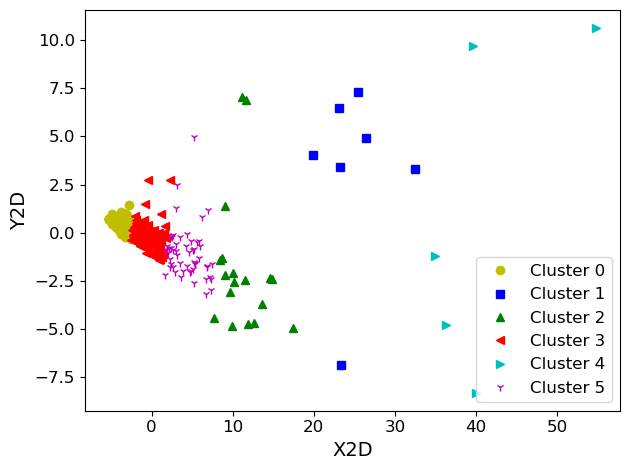

404 (386, 88)


In [20]:
Cluster_StandardScaler_DR_Cluster = Kmeans_Plot(6,Cluster_StandardScaler_DR, 3, -3, -2, -1, "06_StandardScaler_ORI")

    
csv_path = os.path.join(DATA_PATH_OUTPUT, "404Cluster_StandardScaler_DR_Cluster6.csv")
Cluster_StandardScaler_DR_Cluster.to_csv(csv_path, index=True, header=True)
print("404", Cluster_StandardScaler_DR_Cluster.shape)

### Cotovelo (elbow)
Esta curva tem aproximadamente a forma de um braço, e há um “cotovelo” que mostra qual seria uma boa escolha: qualquer valor mais baixo seria dramático, enquanto qualquer valor mais alto não ajudaria muito.

#### Quantidade ótima de clusters?
É o ponto que indica o equilíbrio entre maior homogeneidade dentro do cluster e a maior diferença entre clusters, é o ponto da curva mais distante de uma reta traçada entre os pontos $k$ mínimo e $k$ máximo da curva.

### Silhouette Score (Coeficiente de Silhueta)
O coeficiente de silhueta, que é o coeficiente médio da silhueta em todas as instâncias. O coeficiente de silhueta de uma instância é igual a $(b – a)/\max(a, b)$ onde $a$ é a distância média para as outras instâncias no mesmo cluster (é a distância média intra-cluster) e $b$ é a distância média do cluster mais próximo, ou seja, a distância média até as instâncias do próximo cluster mais próximo (definido como aquele que minimiza $b$, excluindo o próprio cluster da instância). O coeficiente de silhueta pode variar entre $-1$ e $+1$: um coeficiente próximo a $+1$ significa que a instância está bem dentro de seu próprio cluster e distante de outros clusters, enquanto um coeficiente próximo a $0$ significa que ela está perto de um limite de cluster e, finalmente, um coeficiente próximo a $-1$ significa que a instância pode ter sido atribuída ao cluster errado.

### Silhouette Diagram (Diagrama de Silhueta)
Uma visualização ainda mais informativa é obtida quando você plota o coeficiente de silhueta de cada instância, classificado pelo cluster ao qual está atribuído e pelo valor do coeficiente. Isso é chamado de diagrama de silhueta.

As linhas tracejadas verticais representam a pontuação da silhueta para cada número de clusters. Quando a maioria das instâncias em um cluster tem um coeficiente mais baixo do que essa pontuação (ou seja, se muitas das instâncias param antes da linha tracejada, terminando à esquerda dela), o cluster é bastante ruim, pois isso significa que suas instâncias são muito perto de outros clusters.
Bons clusters têm a maioria das instâncias estendidas além da linha tracejada, para a direita e mais próximas de US$ 1,0$. E todos os clusters com tamanhos semelhantes.

#### A função a seguir faz todas as 4 análises acima
 - Gráfico cotovelo
 - Gráfico Silhouette Score
 - Gráfico Silhouette Diagram
 - Número ideal de clusters na última linha

In [21]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter


# df = dataframe
# plot X_Axis, Y_Axis saving in fig_name
def Kmeans_Plot_Metrics(df,X_Axis, Y_Axis, fig_name):

    first = X_Axis
    end = Y_Axis
    
    
    #COTOVELO
    kmeans_per_k = [
    KMeans(n_clusters=j,n_init=10,random_state=42).fit(df[df.columns[first:end]])
        for j in range(1, 10)]
    #print(kmeans_per_k)
    inertias = [model.inertia_ for model in kmeans_per_k]
    #print(inertias)
    plt.figure(figsize=(8, 3.5))
    plt.plot(range(2, 10), inertias[1:], "bo-")
    plt.xlabel("$k$", fontsize=14)
    plt.ylabel("Inertia", fontsize=14)
    save_fig(fig_name + "_Cotovelo_vs_k_plot")
    plt.show()
    
    
    #SILHOUETTE SCORES
    silhouette_scores = [silhouette_score(df[df.columns[first:end]], model.labels_)
                     for model in kmeans_per_k[1:]]
    plt.figure(figsize=(8, 3))
    plt.plot(range(2, 10), silhouette_scores, "bo-")
    plt.xlabel("$k$", fontsize=14)
    plt.ylabel("Silhouette score", fontsize=14)
    #plt.axis([1.8, 8.5, 0.55, 0.7])
    save_fig(fig_name + "_silhouette_score_vs_k_plot")
    plt.show()
    
    
    #SILHOUETTE COEFFICIENTS
    plt.figure(figsize=(11, 9))
    for j in (3, 4, 5, 6):
        plt.subplot(2, 2, j - 2)
        y_pred = kmeans_per_k[j - 1].labels_
        silhouette_coefficients = silhouette_samples(df[df.columns[first:end]], y_pred)
        padding = len(df[df.columns[first:end]]) // 30
        pos = padding
        ticks = []
        for i in range(j):
            coeffs = silhouette_coefficients[y_pred == i]
            coeffs.sort()
            color = mpl.cm.Spectral(i / j)
            plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs, facecolor=color, edgecolor=color, alpha=0.7)
            ticks.append(pos + len(coeffs) // 2)
            pos += len(coeffs) + padding

        plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
        plt.gca().yaxis.set_major_formatter(FixedFormatter(range(j)))
        if j in (3, 5):
            plt.ylabel("Cluster")
            
        if j in (5, 6):
            plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
            plt.xlabel("Silhouette Coefficient")
        else:
            plt.tick_params(labelbottom=False)
        plt.axvline(x=silhouette_scores[j - 2], color="red", linestyle="--")
        plt.title("$k={}$".format(j), fontsize=16)
    save_fig(fig_name + "_silhouette_analysis_plot")
    plt.show()
    # ponto que indica o equilíbrio entre maior homogeneidade dentro do cluster
    # e a maior diferença entre clusters, é o ponto da curva mais distante de uma reta traçada
    x1, y1 = 1, inertias[0]
    x2, y2 = 9, inertias[len(inertias)-1]

    distances = []
    for i in range(0,len(inertias)):
        x0 = i+1
        y0 = inertias[i]
        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)
        print(i, inertias[i], numerator/denominator, x0, x1, y1)
        max_distance = max(distances)
        max_distance_k = (distances.index(max_distance) + 1)
        
    return (max_distance_k)
    #return(0)    
        

Saving figure 07_StandardScaler_ORI_Cotovelo_vs_k_plot


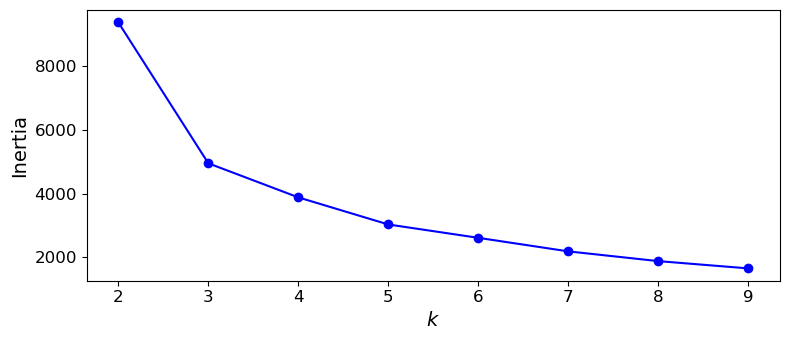

Saving figure 07_StandardScaler_ORI_silhouette_score_vs_k_plot


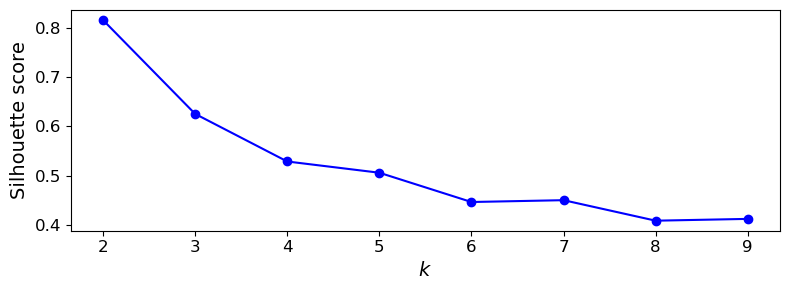

Saving figure 07_StandardScaler_ORI_silhouette_analysis_plot


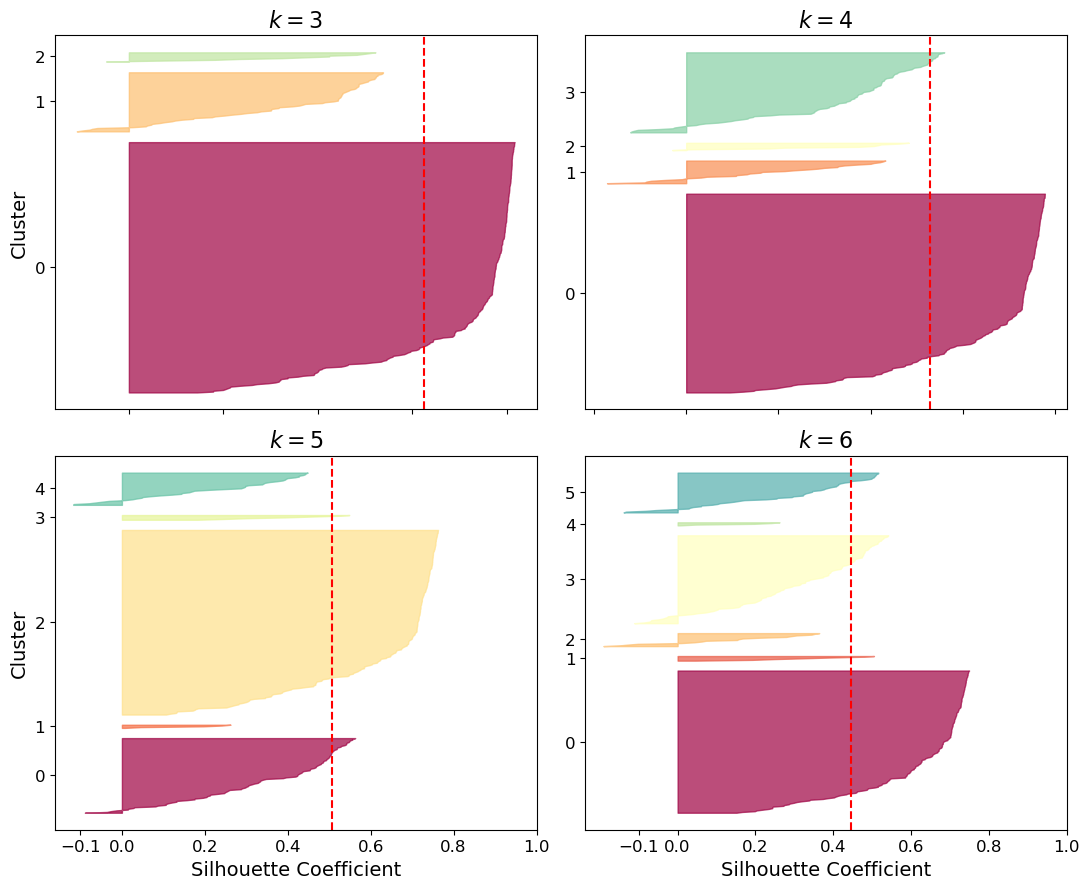

0 22040.59831889896 6.576434462232608e-16 1 1 22040.59831889896
1 9388.844683706884 3.961797350508605 2 1 22040.59831889896
2 4950.760131969046 4.702336839086173 3 1 22040.59831889896
3 3878.0880498120696 4.123020211459092 4 1 22040.59831889896
4 3024.678837183169 3.457712507843857 5 1 22040.59831889896
5 2604.2941062268796 2.622580149519024 6 1 22040.59831889896
6 2177.8491412970047 1.7898245093373504 7 1 22040.59831889896
7 1870.9789271158975 0.9101737359302793 8 1 22040.59831889896
8 1641.9371651599806 6.576434462232608e-16 9 1 22040.59831889896
 NUMERO IDEAL DE CLUSTERS = 3


In [22]:
max_distance = Kmeans_Plot_Metrics(Cluster_StandardScaler_DR, 3, -3, "07_StandardScaler_ORI")
print (" NUMERO IDEAL DE CLUSTERS = "+ str(max_distance))

### Resultado da análise de métricas para número de clusters ideal

Os resultados acima mostram que o número ideal de clusters é 3, mas com um pequena diferença para o valor 4.

# A mesma análise exploratória usando somente PCA já que temos variância explicada > 95%

Percebe-se nos resultados abaixo que o uso do PCA altera muito pouco a forma como os clusters são formados, pequenas alterações nos bairros próximos aos limites dos clusters.

Saving figure 08_StandardScaler_PCA_Cotovelo_vs_k_plot


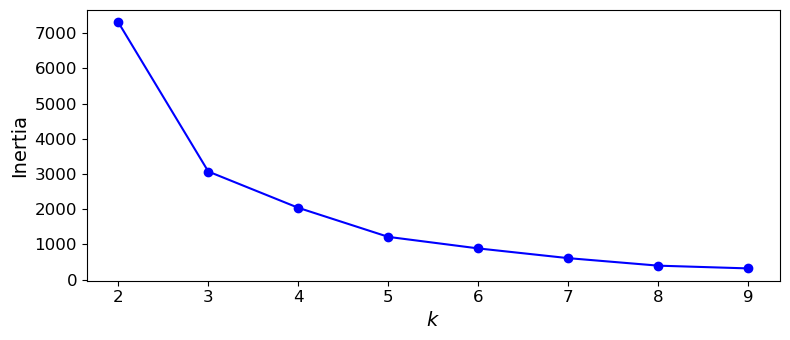

Saving figure 08_StandardScaler_PCA_silhouette_score_vs_k_plot


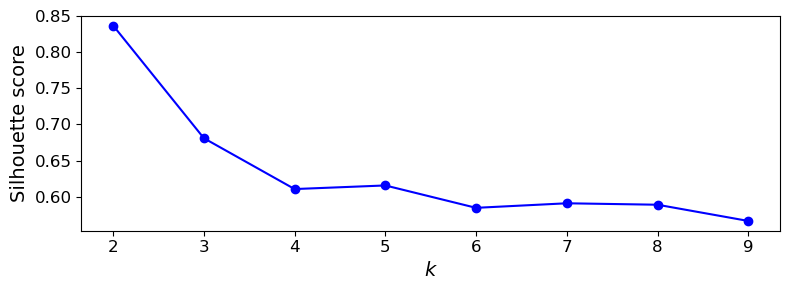

Saving figure 08_StandardScaler_PCA_silhouette_analysis_plot


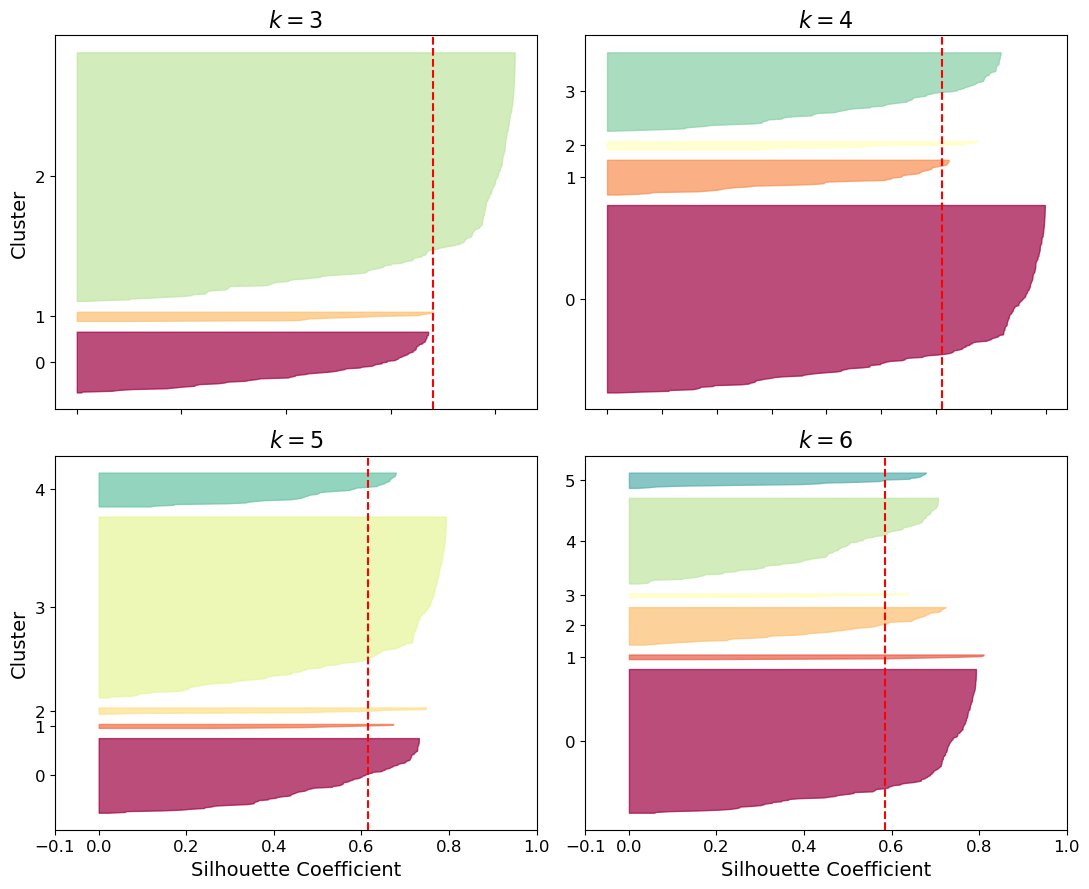

0 19927.528772396145 6.75489612665816e-16 1 1 19927.528772396145
1 7311.468045973215 4.1474996768148635 2 1 19927.528772396145
2 3072.289937163514 4.877133761138908 3 1 19927.528772396145
3 2041.6424496733039 4.297650013251329 4 1 19927.528772396145
4 1215.6771293376253 3.6346535592118214 5 1 19927.528772396145
5 887.872900113513 2.768401582736328 6 1 19927.528772396145
6 611.5615526428179 1.8811399112660445 7 1 19927.528772396145
7 398.3818732600087 0.968119784532173 8 1 19927.528772396145
8 320.2465229055537 6.75489612665816e-16 9 1 19927.528772396145
 NUMERO IDEAL DE CLUSTERS = 3


In [23]:
max_distance = Kmeans_Plot_Metrics(Cluster_StandardScaler_DR, -2, -1, "08_StandardScaler_PCA")
print (" NUMERO IDEAL DE CLUSTERS = "+ str(max_distance))

### Resultado da análise de métricas para número de clusters ideal

Os resultados acima mostram que o número ideal de clusters é 3, mas com um pequena diferença para o valor 4.
Comparando o uso de PCA e base original, o PCA ficou muito semelhante mas com pequena vantagem nos diagramas pois todos os agrupamentos alcançam a linha tracejada.

## Divisão em dois grupos (k = 2)

Saving figure 09_StandardScaler_PCA_Cluster_KM_2


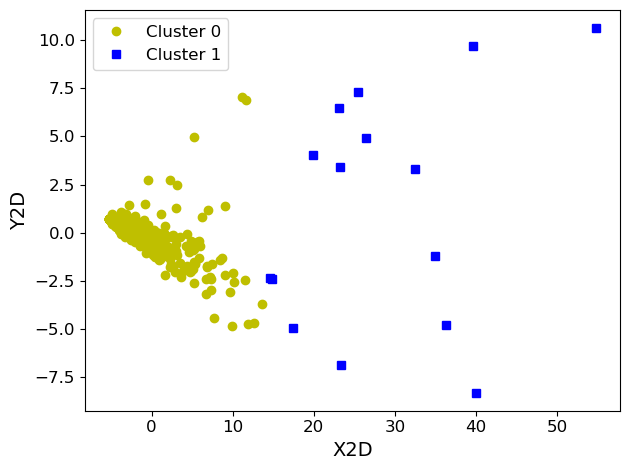

404 (386, 88)


In [24]:
Cluster_StandardScaler_DR_Cluster = Kmeans_Plot(2,Cluster_StandardScaler_DR, -2, -1, -2, -1, "09_StandardScaler_PCA")
    
csv_path = os.path.join(DATA_PATH_OUTPUT, "404Cluster_StandardScaler_PCA_Cluster2.csv")
Cluster_StandardScaler_DR_Cluster.to_csv(csv_path, index=True, header=True)
print("404", Cluster_StandardScaler_DR_Cluster.shape)

## Divisão em três grupos (k = 3)

Saving figure 10_StandardScaler_PCA_Cluster_KM_3


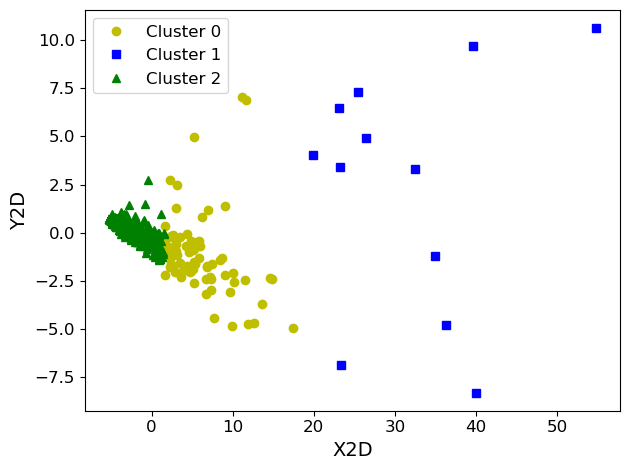

404 (386, 88)
504 (386, 4)


In [25]:
Cluster_StandardScaler_DR_Cluster = Kmeans_Plot(3,Cluster_StandardScaler_DR, -2, -1, -2, -1, "10_StandardScaler_PCA")

    
csv_path = os.path.join(DATA_PATH_OUTPUT, "404Cluster_StandardScaler_PCA_Cluster3.csv")
Cluster_StandardScaler_DR_Cluster.to_csv(csv_path, index=True, header=True)
print("404", Cluster_StandardScaler_DR_Cluster.shape)

columns_titles = ["Cód.","Município","Bairro","pred"]
PCA_Cluster3 = Cluster_StandardScaler_DR_Cluster.loc[:,columns_titles]

# sort Dataframe columns
PCA_Cluster3 = PCA_Cluster3.sort_values(by = ["Cód."])
PCA_Cluster3 = PCA_Cluster3.reset_index(drop=True)


### Drop index while exporting to CSV
csv_path = os.path.join(DATA_PATH_OUTPUT, "504_PCA_Cluster3.csv")
PCA_Cluster3.to_csv(csv_path, index=False, header=True)
print("504", PCA_Cluster3.shape)



## Divisão em quatro grupos (k = 4)

Saving figure 11_StandardScaler_PCA_Cluster_KM_4


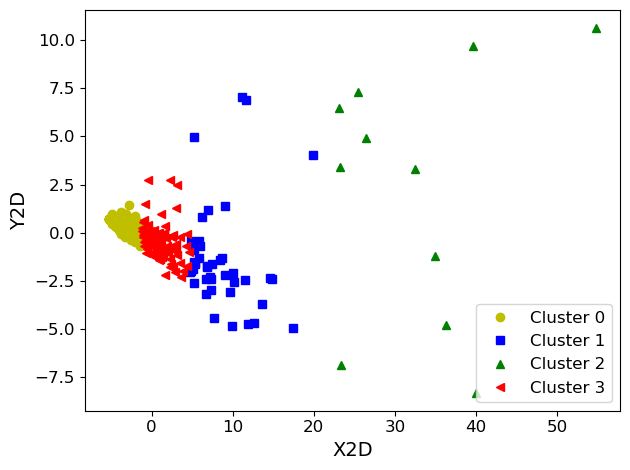

404 (386, 88)


In [26]:
Cluster_StandardScaler_DR_Cluster = Kmeans_Plot(4,Cluster_StandardScaler_DR, -2, -1, -2, -1, "11_StandardScaler_PCA")

    
csv_path = os.path.join(DATA_PATH_OUTPUT, "404Cluster_StandardScaler_PCA_Cluster4.csv")
Cluster_StandardScaler_DR_Cluster.to_csv(csv_path, index=True, header=True)
print("404", Cluster_StandardScaler_DR_Cluster.shape)

## Divisão em cinco grupos (k = 5)

Saving figure 12_StandardScaler_PCA_Cluster_KM_5


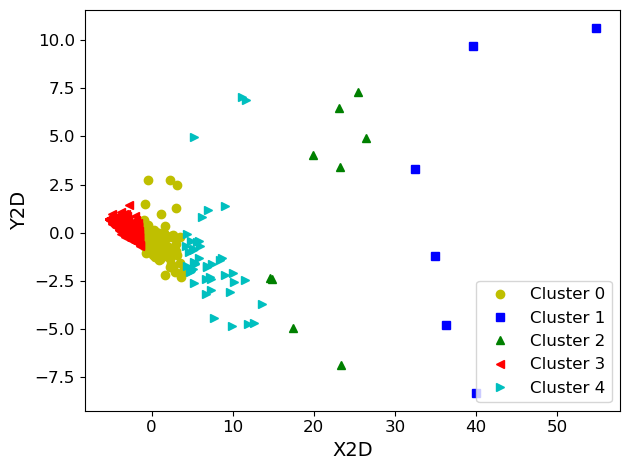

404 (386, 88)


In [27]:
Cluster_StandardScaler_DR_Cluster = Kmeans_Plot(5,Cluster_StandardScaler_DR, -2, -1, -2, -1, "12_StandardScaler_PCA")

    
csv_path = os.path.join(DATA_PATH_OUTPUT, "404Cluster_StandardScaler_PCA_Cluster5.csv")
Cluster_StandardScaler_DR_Cluster.to_csv(csv_path, index=True, header=True)
print("404", Cluster_StandardScaler_DR_Cluster.shape)

## Divisão em seis grupos (k = 6)

Saving figure 13_StandardScaler_PCA_Cluster_KM_6


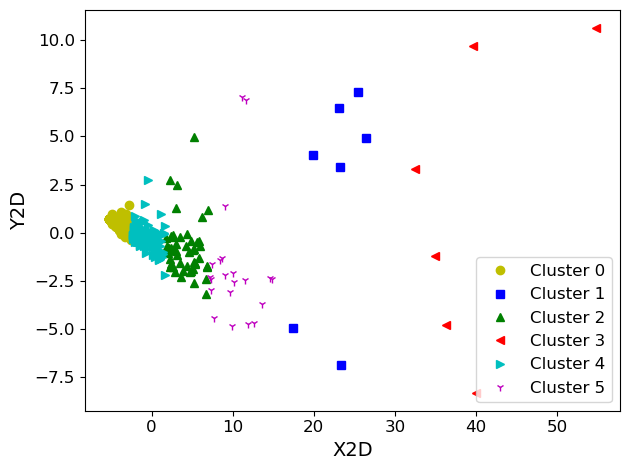

404 (386, 88)


In [28]:
Cluster_StandardScaler_DR_Cluster = Kmeans_Plot(6,Cluster_StandardScaler_DR, -2, -1, -2, -1, "13_StandardScaler_PCA")

    
csv_path = os.path.join(DATA_PATH_OUTPUT, "404Cluster_StandardScaler_PCA_Cluster6.csv")
Cluster_StandardScaler_DR_Cluster.to_csv(csv_path, index=True, header=True)
print("404", Cluster_StandardScaler_DR_Cluster.shape)